In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [4]:
# Load Data
data = pd.read_csv("product_reviews.csv")
data.head()

,product_id,product_title,category,review_text,rating,sentiment
0,4589130,Stainless Steel Blender,Home & Kitchen,Fast shipping and great packaging.,5,Positive
1,4716121,Long-Wear Matte Lipstick,Beauty,Highly recommend. Excellent quality.,5,Positive
2,9640962,Electric Toothbrush,Health & Personal Care,"Terrible experience, do not buy.",1,Negative
3,4442583,Hydrating Facial Serum,Beauty,"Does the job, but not impressed.",4,Positive
4,9757659,LEGO Building Kit,Toys & Games,Exactly what I needed!,5,Positive


In [5]:
data.shape

(4000000, 6)

## Slice the Dataset for Memory Purposes

In [7]:
df_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Slice the first 1 million rows (or fewer if your dataset is smaller)
df = df_shuffled.iloc[:5_000]

In [8]:
df.shape

(5000, 6)

## EDA

In [10]:
missing_values = df.isnull().sum().sort_values(ascending = False)
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [11]:
df.columns

Index(['product_id', 'product_title', 'category', 'review_text', 'rating',
       'sentiment'],
      dtype='object')

In [12]:
df['sentiment'].value_counts()

sentiment
Positive    2539
Neutral     1561
Negative     900
Name: count, dtype: int64

In [13]:
df['rating'].value_counts()

rating
5    1554
4    1466
3     944
2     641
1     395
Name: count, dtype: int64

In [14]:
df.groupby('category')['sentiment'].value_counts()

category                sentiment
Beauty                  Positive     306
                        Neutral      184
                        Negative     103
Books                   Positive     302
                        Neutral      205
                        Negative     118
Electronics             Positive     291
                        Neutral      167
                        Negative     124
Fashion                 Positive     331
                        Neutral      208
                        Negative     103
Health & Personal Care  Positive     360
                        Neutral      211
                        Negative     110
Home & Kitchen          Positive     314
                        Neutral      180
                        Negative     116
Sports & Outdoors       Positive     314
                        Neutral      199
                        Negative     133
Toys & Games            Positive     321
                        Neutral      207
                       

In [15]:
pd.crosstab(df.category, df.rating, margins=True, margins_name = "Count")

rating,1,2,3,4,5,Count
category,,,,,,
Beauty,59,60,120,162,192,593
Books,46,90,127,170,192,625
Electronics,45,93,101,172,171,582
Fashion,47,72,108,212,203,642
Health & Personal Care,58,64,130,208,221,681
Home & Kitchen,54,80,107,176,193,610
Sports & Outdoors,46,111,120,183,186,646
Toys & Games,40,71,131,183,196,621
Count,395,641,944,1466,1554,5000


## **Preprocessing**

In [17]:
#Encode Sentiment Labels: 0 = Negative, 1 = Neutral, 2 = Positive

label_encoder = LabelEncoder()
df.loc[:, 'sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])

C:\Users\ich\AppData\Local\Temp\ipykernel_17932\2707855120.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'sentiment_encoded'] = label_encoder.fit_transform(df['sentiment'])


In [18]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df['review_text'].values,
    df['sentiment_encoded'].values,
    test_size = 0.2,
    random_state = 42,
    stratify = df['sentiment_encoded']
)


In [19]:
# Text Vectorization
MAX_VOCAB = 20000
MAX_LEN = 200

vectorizer = TextVectorization(max_tokens=MAX_VOCAB, output_mode='int', output_sequence_length=MAX_LEN)
vectorizer.adapt(X_train)

# Apply the vectorizer to the text data
X_train_vec = vectorizer(X_train)
X_test_vec = vectorizer(X_test)

In [20]:
# Or convert inputs to numpy (if memory allows)
X_train_vec_np = X_train_vec.numpy()
X_test_vec_np = X_test_vec.numpy()

## Build the Model

In [22]:
model = Sequential([
    Embedding(input_dim = MAX_VOCAB, output_dim = 128, input_length = MAX_LEN),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(3, activation = 'softmax')
])

In [23]:
#compile the model

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [24]:
# Setup Callbacks
callback = EarlyStopping(
    monitor = 'val_loss',      # Now monitors validation loss
    patience = 3,              # Number of epochs with no improvement before stopping
    mode = 'min',              # Lower loss is better
    restore_best_weights = True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor ='val_loss',      # Now monitors validation loss
    save_best_only = True,
    mode = 'min',              # Lower loss is better
    verbose = 1
)


In [56]:
#fit and train the model

history = model.fit(
    X_train_vec.numpy(),  # Use original tensor's numpy array
    y_train,              # Keep as NumPy (from train_test_split)
    validation_data = (X_test_vec_np, y_test),  # Both NumPy now
    epochs = 15,
    batch_size = 32,
    validation_batch_size = 32,
    callbacks = [callback, checkpoint]
)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8180 - loss: 0.4359
Epoch 1: val_loss did not improve from 0.43512
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.8180 - loss: 0.4360 - val_accuracy: 0.8160 - val_loss: 0.4388
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8054 - loss: 0.4490
Epoch 2: val_loss did not improve from 0.43512
125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 196ms/step - accuracy: 0.8055 - loss: 0.4490 - val_accuracy: 0.8160 - val_loss: 0.4370
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8069 - loss: 0.4550
Epoch 3: val_loss did not improve from 0.43512
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.8070 - loss: 0.4550 - val_accuracy: 0.8160 - val_loss: 0.4418
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8165 - loss: 0.4345
Epoch 4: val_loss did not improve from 0.43512
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - accuracy: 0.8164 - loss: 0.4346 - val_accuracy: 0.8160

125/125 ━━━━━━━━━━━━━━━━━━━━ 36s 159ms/step - accuracy: 0.8203 - loss: 0.4451 - val_accuracy: 0.8160 - val_loss: 0.4330
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7991 - loss: 0.4537
Epoch 8: val_loss did not improve from 0.43300
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 201ms/step - accuracy: 0.7992 - loss: 0.4536 - val_accuracy: 0.8160 - val_loss: 0.4349
Epoch 9/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8179 - loss: 0.4312
Epoch 9: val_loss did not improve from 0.43300
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - accuracy: 0.8179 - loss: 0.4313 - val_accuracy: 0.8160 - val_loss: 0.4348
Epoch 10/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8167 - loss: 0.4463
Epoch 10: val_loss did not improve from 0.43300
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.8167 - loss: 0.4463 - val_accuracy: 0.8160 - val_loss: 0.4360


## Evaluate the Model

In [60]:
# Evaluate the Model
test_loss, test_acc, = model.evaluate(X_test_vec_np, y_test)
print(f"\nTest Accuracy: {test_acc:.2f}")



32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8106 - loss: 0.4369

Test Accuracy: 0.82


In [62]:
# inspect metrics

y_pred = model.predict(X_test_vec_np)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes,
                            target_names=['Negative', 'Neutral', 'Positive']))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
              precision    recall  f1-score   support

    Negative       0.88      0.84      0.86       180
     Neutral       0.69      0.73      0.71       312
    Positive       0.87      0.86      0.87       508

    accuracy                           0.82      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.82      0.82      1000



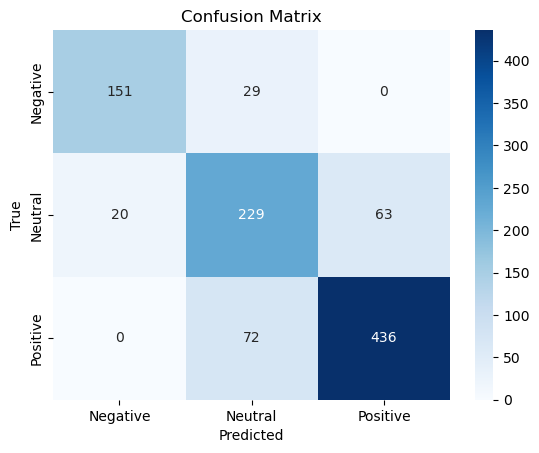

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

labels = ['Negative', 'Neutral', 'Positive']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

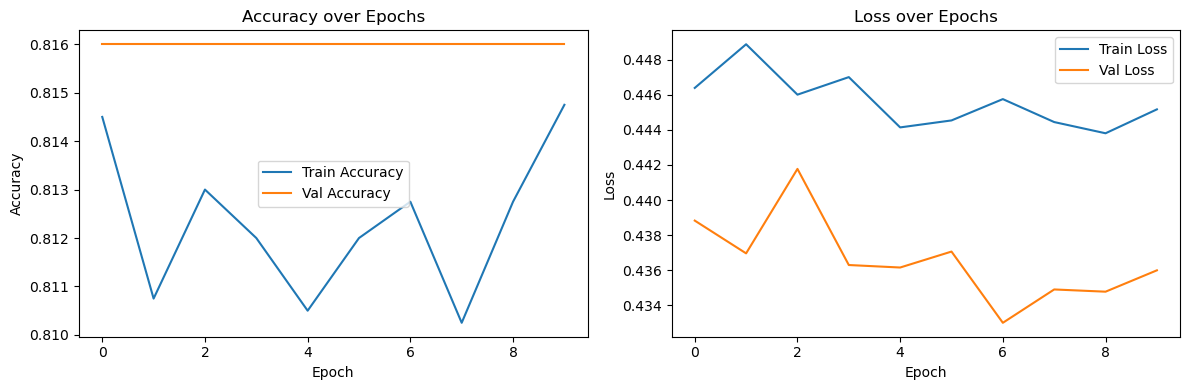

In [66]:
# Plot Training History
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
